# PilotD2Redo - QC and exploratory analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import scanpy as sc
import rapids_singlecell as rsc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.autolayout'] = True

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

from preprocess import _convert_oak_path
import qc_plots

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [4]:
# Read config
experiment_name = 'PilotD2Redo_Lane2_Ultima'
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

config = config[experiment_name]
datadir = _convert_oak_path(config['datadir'])
sample_metadata_csv = _convert_oak_path(config['sample_metadata'])

PLOTDIR = f'../../results/{experiment_name}/'
sc.settings.figdir = PLOTDIR

def save_plot(pl_name, plot_dir = None):
    if plot_dir is None:
        plot_dir = PLOTDIR
    plt.savefig(f'{plot_dir}/{pl_name}.pdf');
    plt.savefig(f'{plot_dir}/{pl_name}.png');

## Read merged dataset

In [5]:
sample_metadata = pd.read_csv(sample_metadata_csv, index_col=0)
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
sample_metadata

10xrun_id          cell_sample_id   donor_id culture_condition  \
0  PilotD2Redo_Lane2        PilotD2Redo_Day7  CE0010216              Day7   
1  PilotD2Redo_Lane2        PilotD2Redo_Rest  CE0010216              Rest   
2  PilotD2Redo_Lane2   PilotD2Redo_Restim6hr  CE0010216         Restim6hr   
3  PilotD2Redo_Lane2  PilotD2Redo_Restim24hr  CE0010216        Restim24hr   

                            library_id library_prep_kit  \
0        PilotD2Redo_Day7_Lane2_Ultima     GEMX_flex_v2   
1        PilotD2Redo_Rest_Lane2_Ultima     GEMX_flex_v2   
2   PilotD2Redo_Restim6hr_Lane2_Ultima     GEMX_flex_v2   
3  PilotD2Redo_Restim24hr_Lane2_Ultima     GEMX_flex_v2   

                                   probe_hyb_loading GEM_loading  \
0  1M cells/probe, 10uL GEX probe, BC001-004, CRI...          3x   
1  1M cells/probe, 10uL GEX probe, BC005-008, CRI...          3x   
2  1M cells/probe, 10uL GEX probe, BC009-012, CRI...          3x   
3  1M cells/probe, 10uL GEX probe, BC013-016, CRI...          3x   

  sequencing_platform  
0              Ultima  
1              Ultima  
2              Ultima  
3              Ultima

In [12]:
adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.h5ad', backed=False)
adata.var = adata.var[['gene_ids', 'gene_name', 'mt']].copy()
adata.var_names = adata.var[ 'gene_name'].values

In [13]:
adata

AnnData object with n_obs × n_vars = 662843 × 18129
    obs: 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'Unnamed: 0', '10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'library_prep_kit', 'probe_hyb_loading', 'GEM_loading', 'sequencing_platform'
    var: 'gene_ids', 'gene_name', 'mt'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [14]:
if 'guide_id' not in adata.obs:
    # Load assignment of sgRNAs to cells
    sgrna_assignment = pd.read_csv(f'{datadir}/sgrna_assignment.csv', index_col=0)
    sgrna_assignment_index = sgrna_assignment.index.tolist()
    sgrna_assignment = pd.merge(sgrna_assignment, sgrna_library_metadata.rename({"sgrna_id":'guide_id'}, axis=1), how='left')
    sgrna_assignment.index = sgrna_assignment_index

    existing_cols = [col for col in sgrna_assignment.columns if col in adata.obs.columns]
    adata.obs.drop(columns=existing_cols, inplace=True)
    adata.obs = pd.concat([adata.obs, sgrna_assignment.loc[adata.obs_names]], axis=1)
    adata.obs['guide_type'] = np.where(adata.obs['guide_id'].str.startswith('NTC-'), 'non-targeting', 'targeting')

## QC metrics

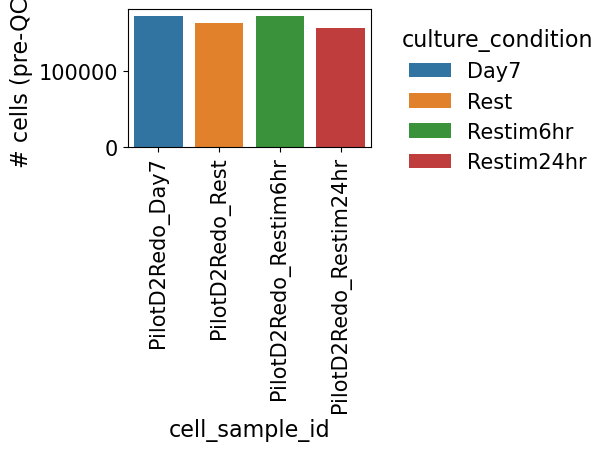

In [15]:
qc_plots.plot_ncells_sample(adata);
save_plot(f'{experiment_name}_n_cells_preQC')

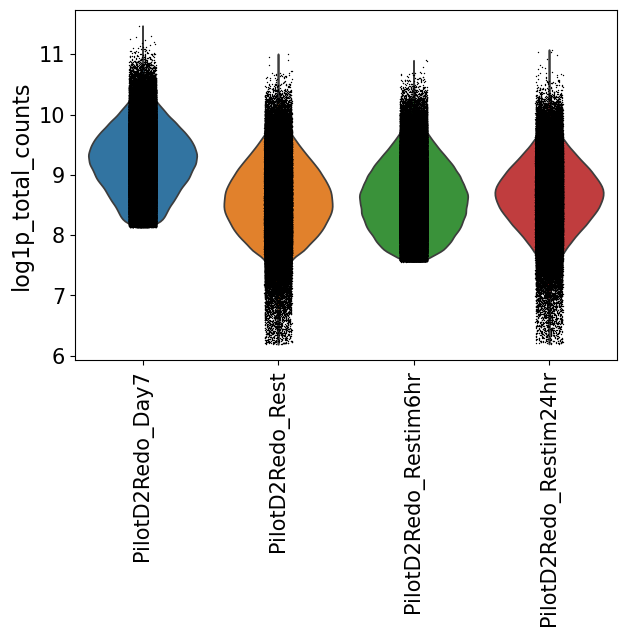

In [16]:
sc.pl.violin(adata, 'log1p_total_counts', groupby='cell_sample_id', rotation=90)

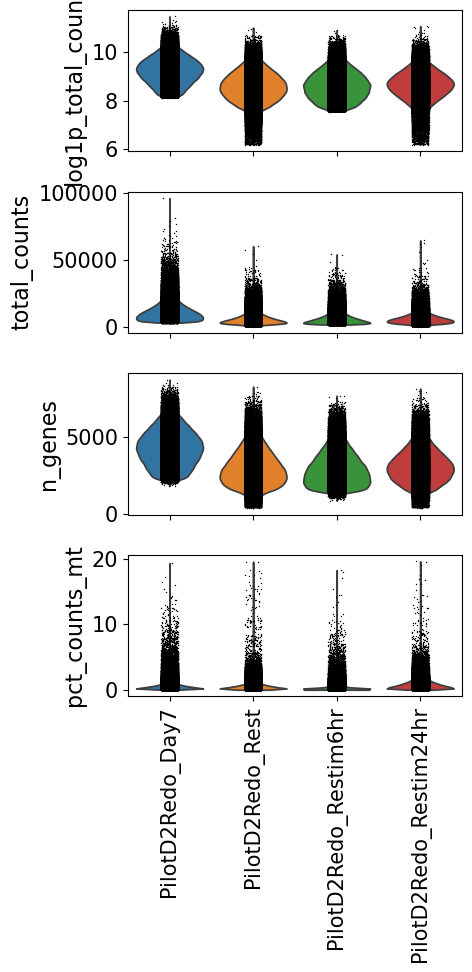

In [17]:
fig, axs = plt.subplots(4,1, figsize=(5,10))
for i,m in enumerate(['log1p_total_counts','total_counts', 'n_genes', 'pct_counts_mt']):
    sc.pl.violin(adata, m, groupby='cell_sample_id', rotation=90, show=False, ax=axs[i]);
    if i != 3:
        # remove x-axis tick labels
        axs[i].set_xticklabels([])

fig.tight_layout()
fig.show()


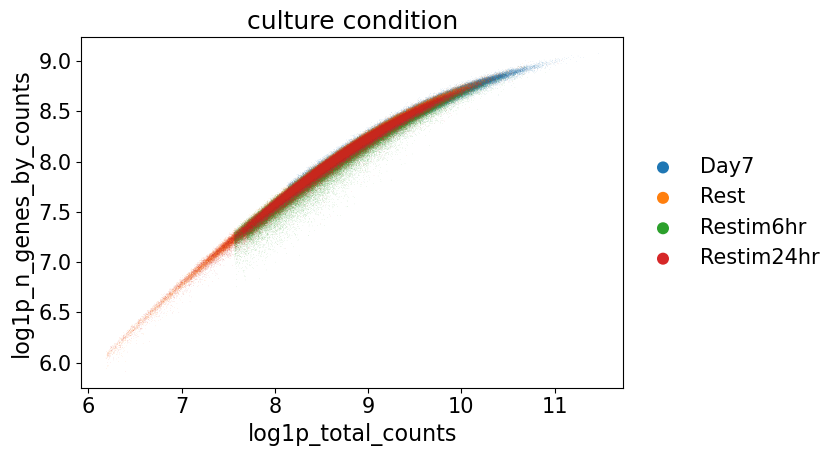

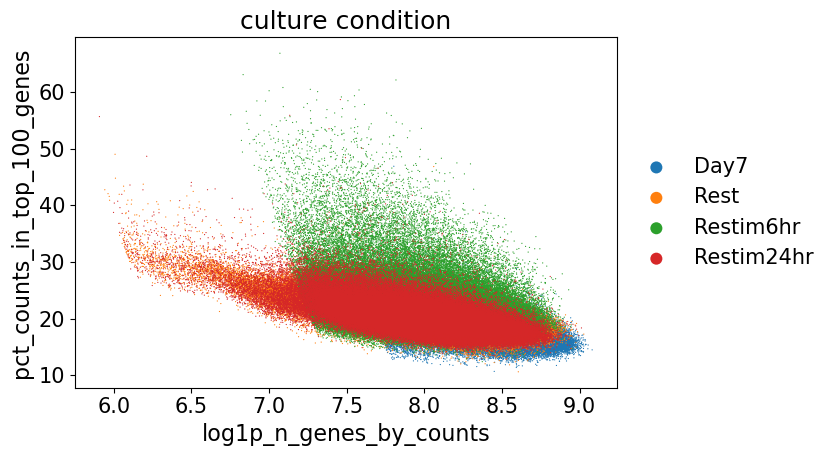

In [18]:
sc.pl.scatter(adata, 'log1p_total_counts', 'log1p_n_genes_by_counts', color='culture_condition')
sc.pl.scatter(adata, 'log1p_n_genes_by_counts', 'pct_counts_in_top_100_genes', color='culture_condition', size=3)

In [19]:
adata.obs[['total_counts', 'n_genes', 'pct_counts_mt', 'cell_sample_id']].groupby('cell_sample_id').mean()

total_counts      n_genes  pct_counts_mt
cell_sample_id                                                  
PilotD2Redo_Day7        12167.270508  4373.038287       0.644951
PilotD2Redo_Rest         6442.792969  3041.262799       0.574615
PilotD2Redo_Restim6hr    6741.679688  3008.878081       0.383620
PilotD2Redo_Restim24hr   6715.967773  3129.489171       0.863579

Estimate fraction of low quality cells (high fraction of mitochondrial genes, low number of captured genes)

In [20]:
adata.obs['low_quality'] = (adata.obs['pct_counts_mt'] > 5) | (adata.obs['n_genes'] < 1000)

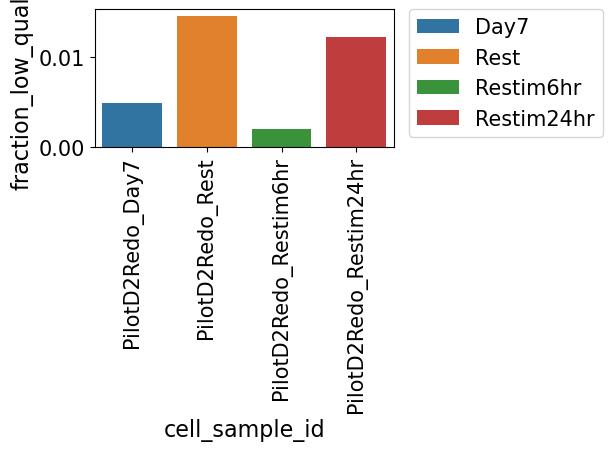

In [21]:
# plot fraction of low_quality cells for each sample_id
low_quality_df = adata.obs.groupby(['cell_sample_id', 'culture_condition'])['low_quality'].mean().reset_index(name='fraction_low_quality')
low_quality_df
sns.barplot(data=low_quality_df, x='cell_sample_id', y='fraction_low_quality', hue='culture_condition', dodge=False);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);


## sgRNA assignment QC metrics

In [22]:
import upsetplot
from upsetplot import from_contents

In [23]:
all_crispr_a = {}
for sample_id in sample_metadata['cell_sample_id']:
    sgrna_h5ad = f"{datadir}{sample_id}.sgRNA.h5ad"
    crispr_a = sc.read_h5ad(sgrna_h5ad)
    all_crispr_a[sample_id] = crispr_a

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/oak/users/emma/data/GWT/PilotD2Redo_Lane2_Ultima/PilotD2Redo_Day7.sgRNA.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

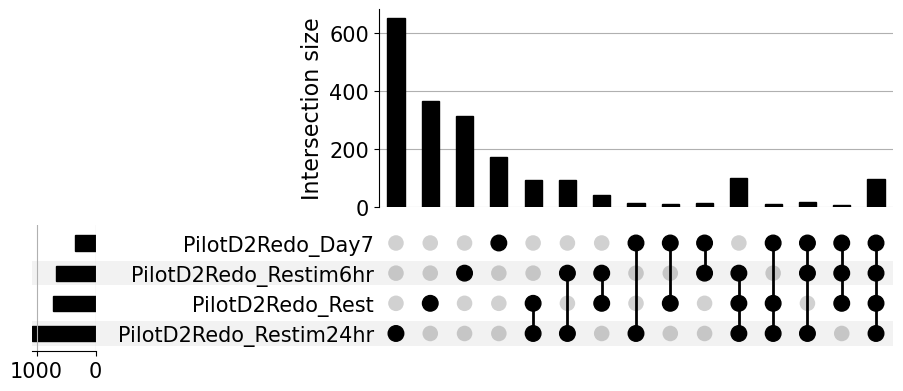

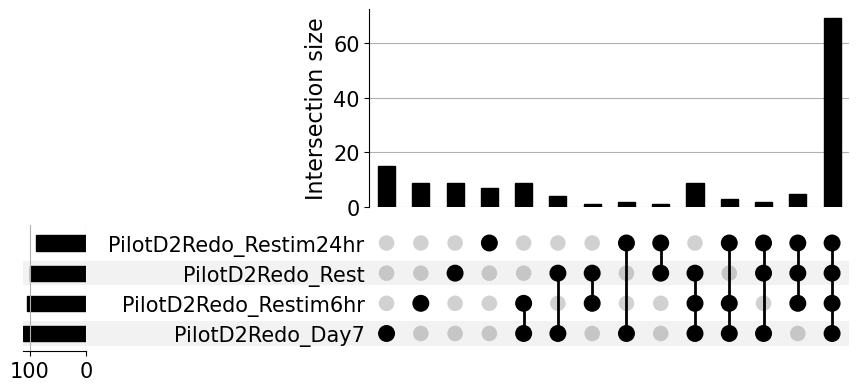

In [17]:
# Get lists of inefficient and nonspecific guides for each sample
all_inefficient = {k:x.var_names[x.var['inefficient']].tolist() for k,x in all_crispr_a.items()}
all_nonspecific = {k:x.var_names[x.var['nonspecific']].tolist() for k,x in all_crispr_a.items()}

inef = from_contents(all_inefficient)
ax_dict = upsetplot.UpSet(inef, subset_size="count").plot()

nons = from_contents(all_nonspecific)
ax_dict = upsetplot.UpSet(nons).plot()

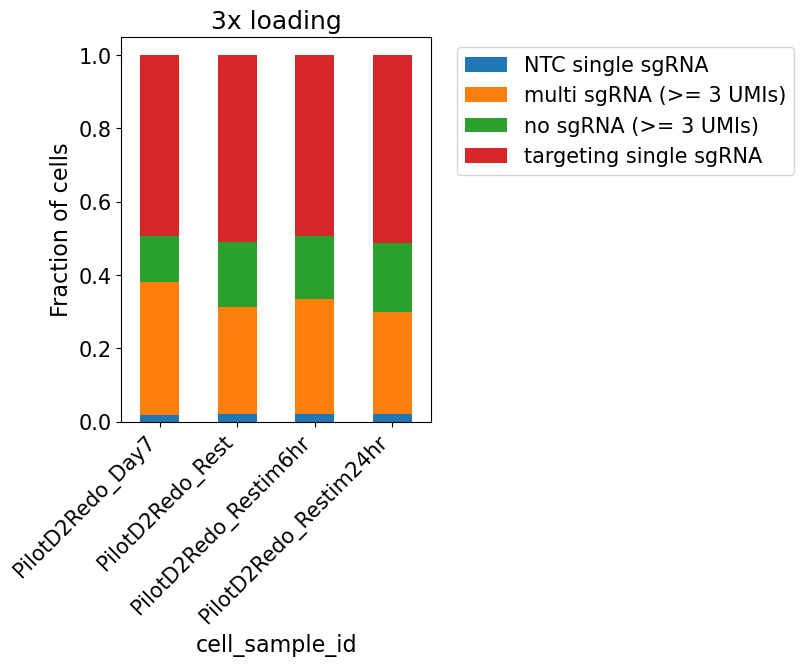

In [24]:
pl_df = adata.obs[['guide_id', 'cell_sample_id', 'low_quality']]
pl_df['group'] = 'targeting single sgRNA'
pl_df['group'] = np.where(adata.obs['guide_id'].str.startswith('NTC'), 'NTC single sgRNA', pl_df['group'])
pl_df['group'] = np.where(adata.obs['guide_id'].isna(), 'no sgRNA (>= 3 UMIs)', pl_df['group'])
pl_df['group'] = np.where(adata.obs['guide_id']  == 'multi_sgRNA', 'multi sgRNA (>= 3 UMIs)', pl_df['group'])
pl_df = pl_df[~pl_df['low_quality']].copy()
# Plot stacked barplot of fraction of cells in each group for each sample

group_counts = pl_df.groupby(['cell_sample_id', 'group']).size().unstack()
group_fractions = group_counts.div(group_counts.sum(axis=1), axis=0)
group_fractions.plot(kind='bar', stacked=True, figsize=(4,5))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fraction of cells')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("3x loading");
plt.tight_layout()

In [25]:
group_counts

group                   NTC single sgRNA  multi sgRNA (>= 3 UMIs)  \
cell_sample_id                                                      
PilotD2Redo_Day7                    3172                    62447   
PilotD2Redo_Rest                    3349                    46912   
PilotD2Redo_Restim6hr               3521                    53903   
PilotD2Redo_Restim24hr              3355                    42744   

group                   no sgRNA (>= 3 UMIs)  targeting single sgRNA  
cell_sample_id                                                        
PilotD2Redo_Day7                       21694                   84587  
PilotD2Redo_Rest                       28201                   81684  
PilotD2Redo_Restim6hr                  29186                   84692  
PilotD2Redo_Restim24hr                 29155                   78758

In [20]:
# no_guide_cells = adata.obs_names[adata.obs['guide_id'].isna()]
# multi_guide_cells = adata.obs_names[adata.obs['guide_id'] == 'multi_sgRNA']

# fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# for i, (sample_id, crispr_a) in enumerate(all_crispr_a.items()):
#     crispr_a.obs['multi_sgrna'] = crispr_a.obs_names.isin(multi_guide_cells)
#     crispr_a.obs['no_sgrna'] = crispr_a.obs_names.isin(no_guide_cells)
#     crispr_a.obs['targeting_umis'] = np.array(crispr_a[:, crispr_a.var['sgrna_type'] == 'targeting'].X.sum(axis=1)).flatten()
#     crispr_a.obs['ntc_umis'] = np.array(crispr_a[:, crispr_a.var['sgrna_type'] == 'NTC'].X.sum(axis=1)).flatten()
#     crispr_a.obs['inefficient_umis'] = np.array(crispr_a[:, crispr_a.var['inefficient']].X.sum(axis=1)).flatten()
#     crispr_a.obs['nonspecific_umis'] = np.array(crispr_a[:, crispr_a.var['nonspecific']].X.sum(axis=1)).flatten()

#     ntc_n = sum(no_sgrna_a.obs['ntc_umis'] > 3)
#     tot_n = no_sgrna_a.n_obs
#     subtitle = f'{ntc_n}/{tot_n} multi sgRNA cells with NTC sgRNAs'
#     no_sgrna_a = crispr_a[crispr_a.obs['multi_sgrna']].copy()
    
#     axes[i].scatter(no_sgrna_a.obs['ntc_umis'], no_sgrna_a.obs['targeting_umis'], s=3)
#     axes[i].set_xscale('log')
#     axes[i].set_yscale('log')
#     axes[i].set_xlabel('NTC sgRNA UMI counts')
#     axes[i].set_ylabel('Targeting sgRNA UMI counts')
#     axes[i].set_title('Multi sgRNA cells - ' + crispr_a.obs['cell_sample_id'][0] + '\n' + subtitle)

# plt.tight_layout()
# plt.show()

## Dimensionality reduction

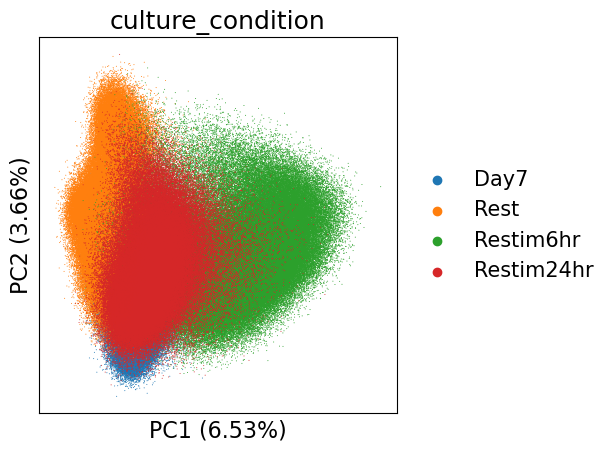

In [26]:
sc.pl.pca(adata, annotate_var_explained=True, color=['culture_condition'], components=['1,2'], wspace=0.5, ncols=3, size=2)

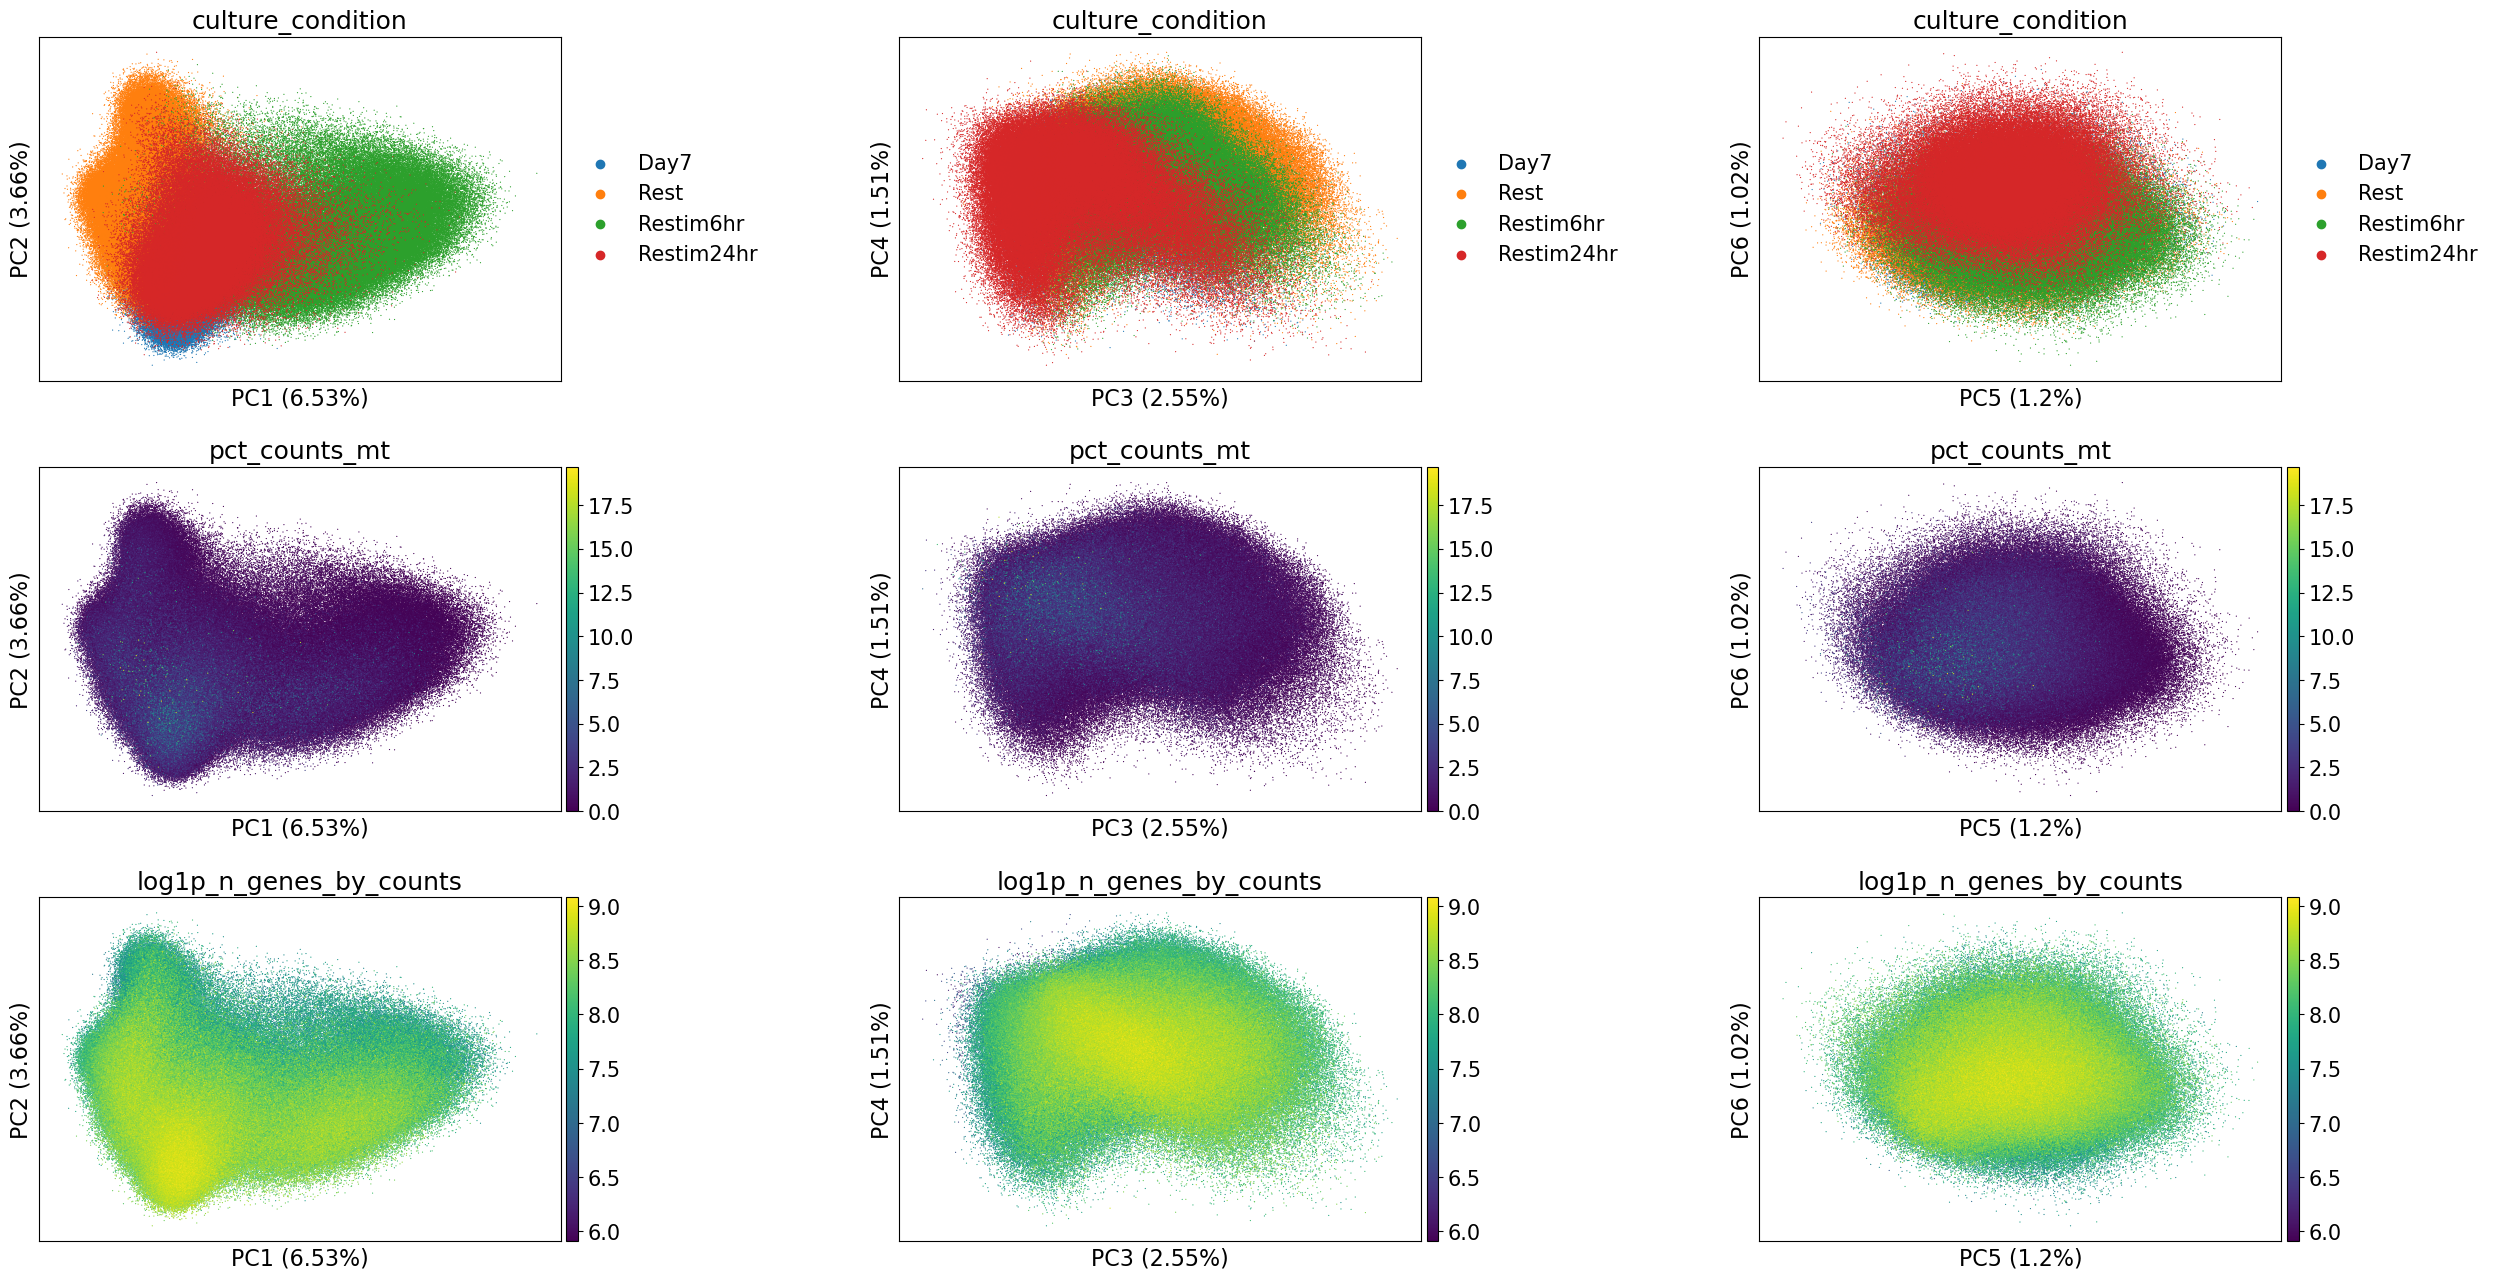

In [27]:
sc.pl.pca(adata, annotate_var_explained=True, color=['culture_condition', 'pct_counts_mt', 'log1p_n_genes_by_counts'], components=['1,2', '3,4', '5,6'], wspace=0.5, ncols=3, size=3)

Visualize genes with top loadings for each PC

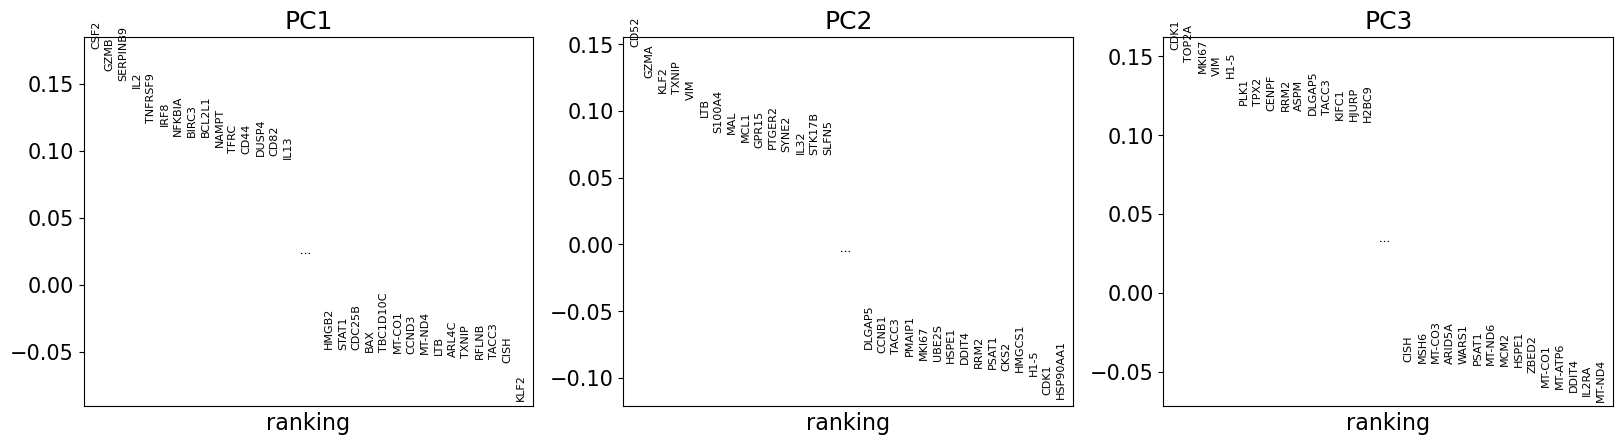

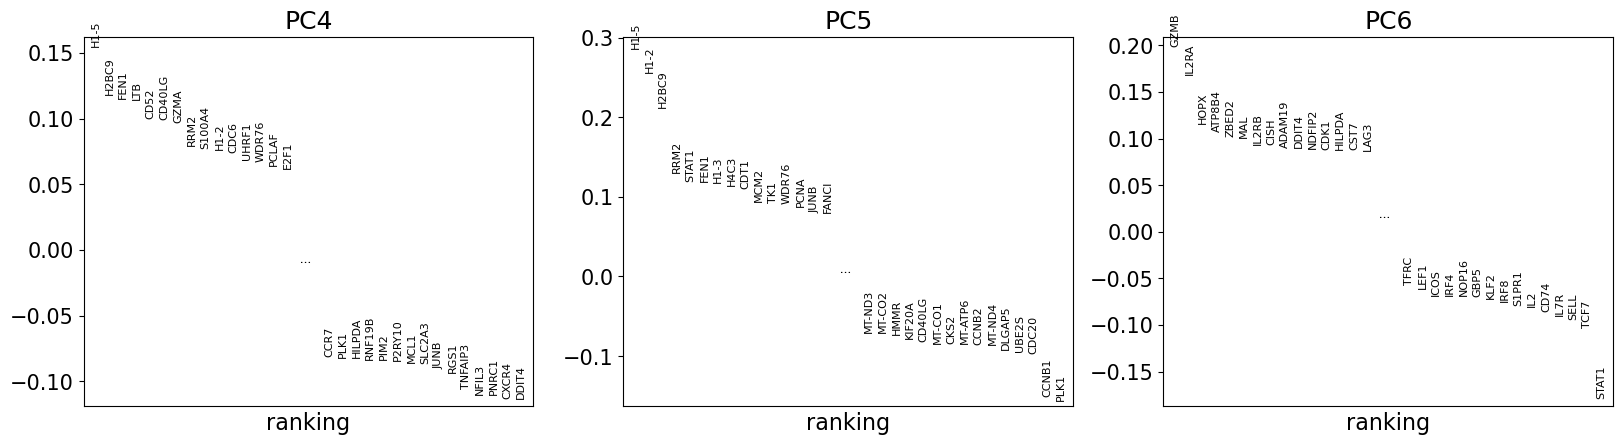

In [23]:
sc.pl.pca_loadings(adata, components='1,2,3');
sc.pl.pca_loadings(adata, components='4,5,6')

## Clustering

In [28]:
rsc.pp.neighbors(adata, n_neighbors=50)
rsc.tl.umap(adata)
rsc.tl.louvain(adata)

In [25]:
# adata.write_h5ad()

In [31]:
adata

AnnData object with n_obs × n_vars = 662843 × 18129
    obs: 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'Unnamed: 0', '10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'library_prep_kit', 'probe_hyb_loading', 'GEM_loading', 'sequencing_platform', 'guide_id', 'top_guide_umi_counts', 'sequence', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type', 'low_quality', 'louvain'
    var: 'gene_ids', 'gene_name', 'mt'
    uns: 'hvg', 'log1p', 'pca', 'cell_sample_id_colors', 'culture_condition_colors', 'neighbors', 'umap', 'louvain'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

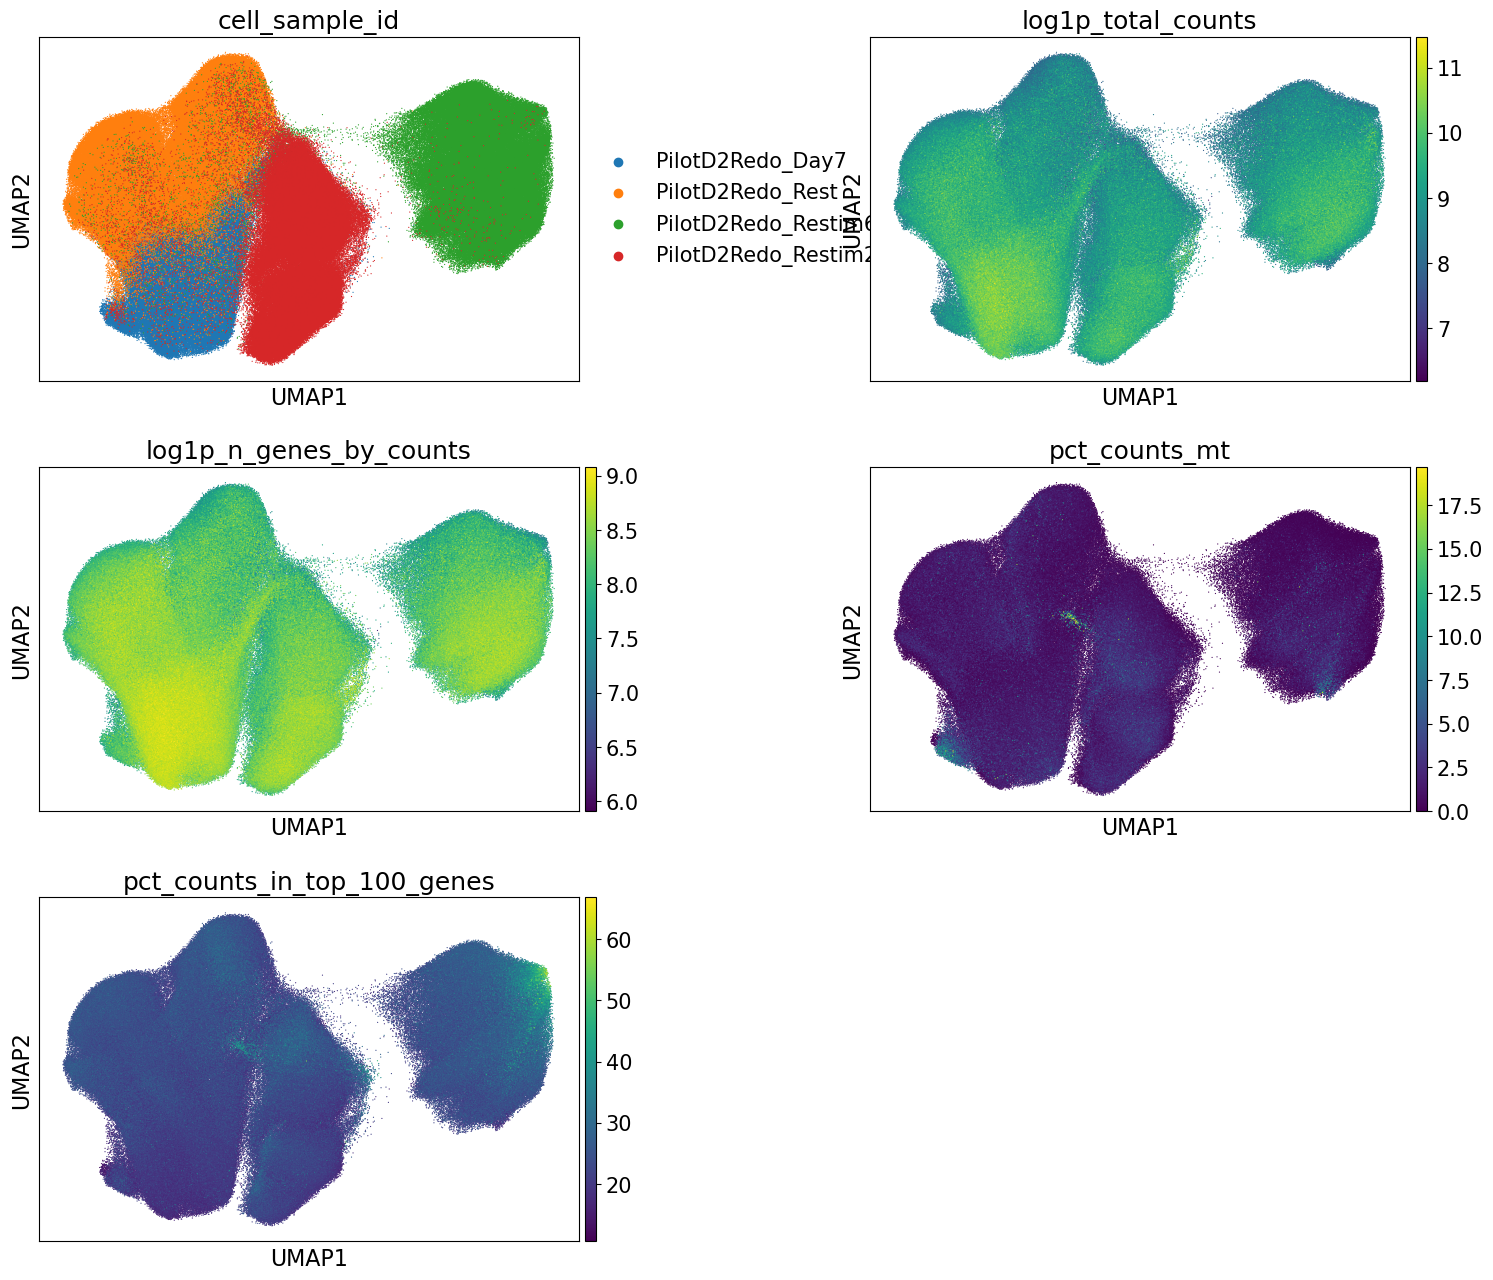

In [32]:
sc.pl.umap(adata, color=['cell_sample_id'] + ['log1p_total_counts','log1p_n_genes_by_counts','pct_counts_mt', 'pct_counts_in_top_100_genes'], wspace=0.4, size=3, ncols=2)

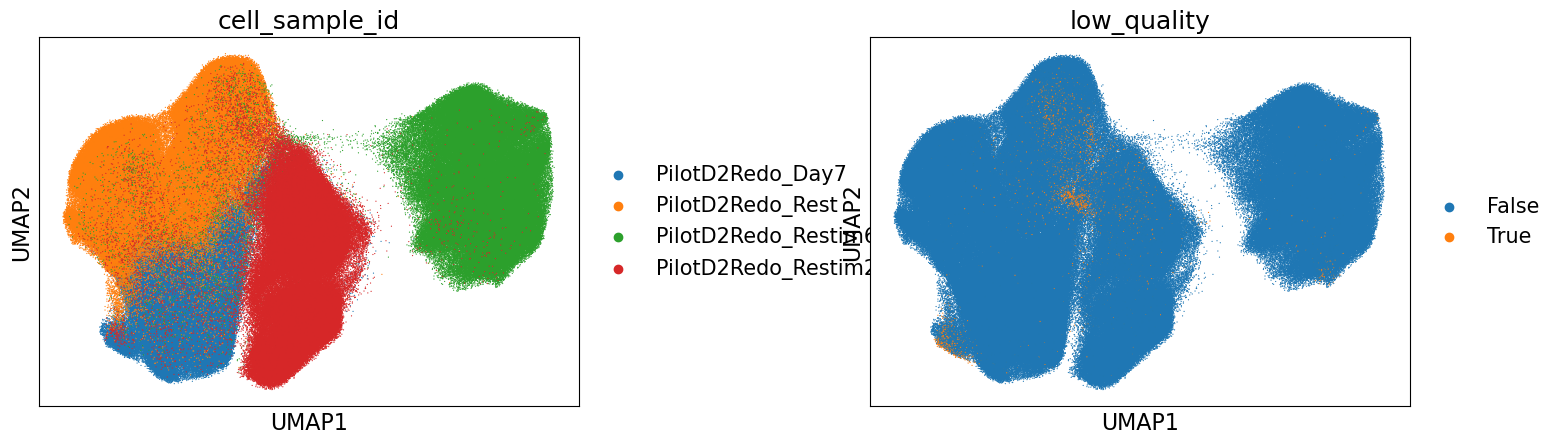

In [33]:
sc.pl.umap(adata, color=['cell_sample_id'] + ['low_quality'], wspace=0.4, size=3)

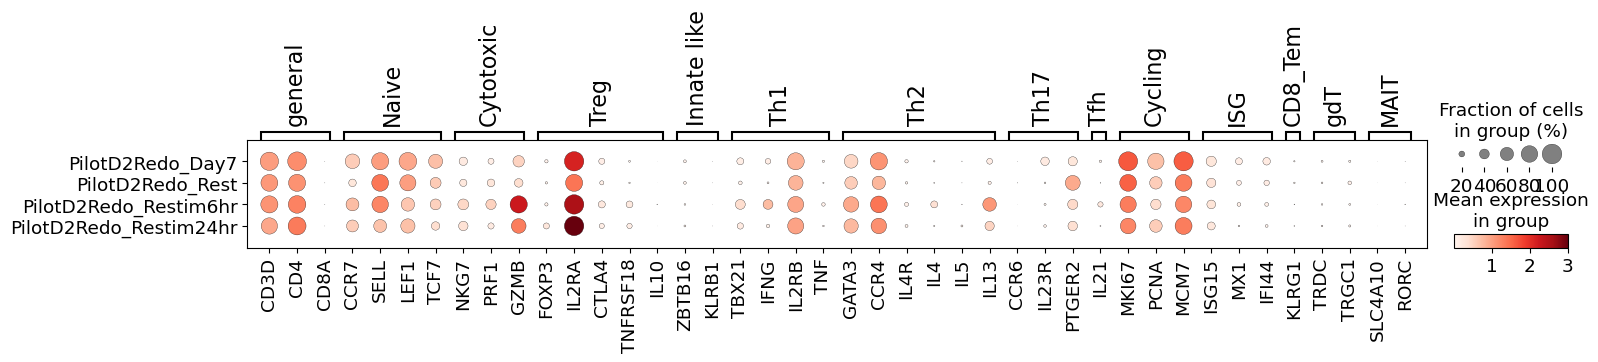

In [34]:
qc_plots.plot_markers_sample_dotplot(adata, save=f'{experiment_name}_markers_sample_dotplot')

In [35]:
# qc_plots.plot_markers_umap(adata, wspace=0.1, size=3, cmap='magma', ncols=5, save=f'{experiment_name}_markers.png')

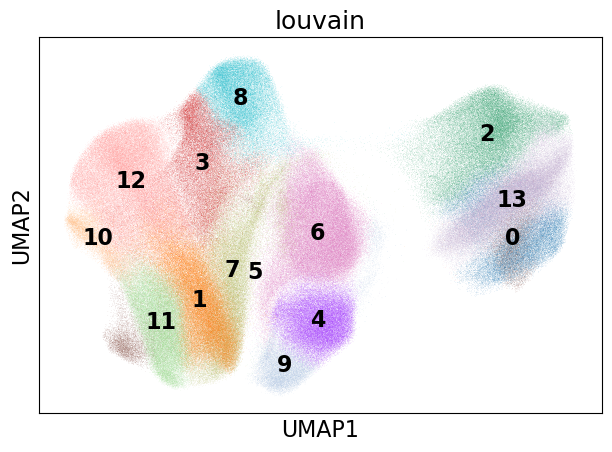

In [36]:
sc.pl.umap(adata, color='louvain', legend_loc='on data')

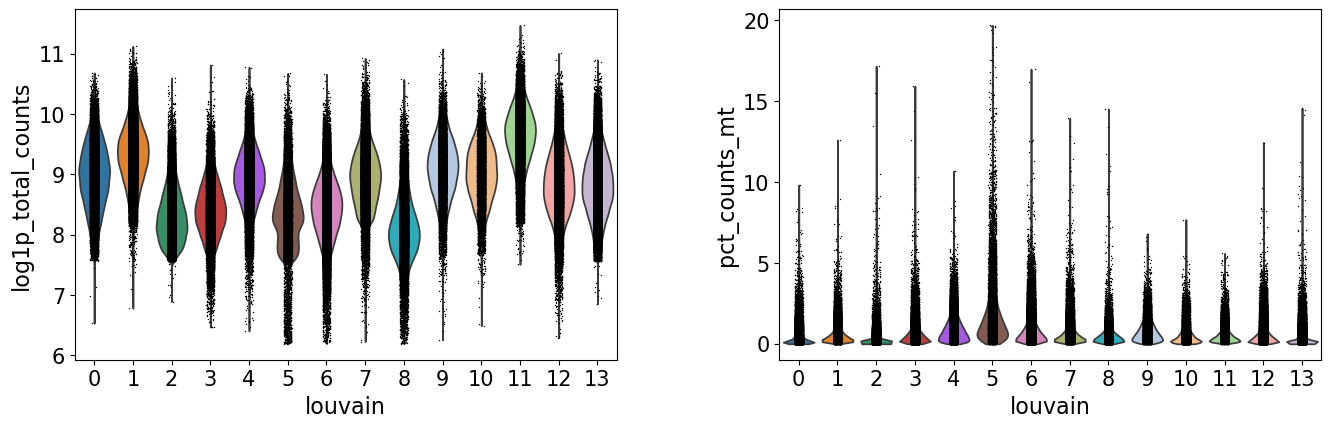

In [37]:
sc.pl.violin(adata, ['log1p_total_counts', 'pct_counts_mt'], groupby='louvain')

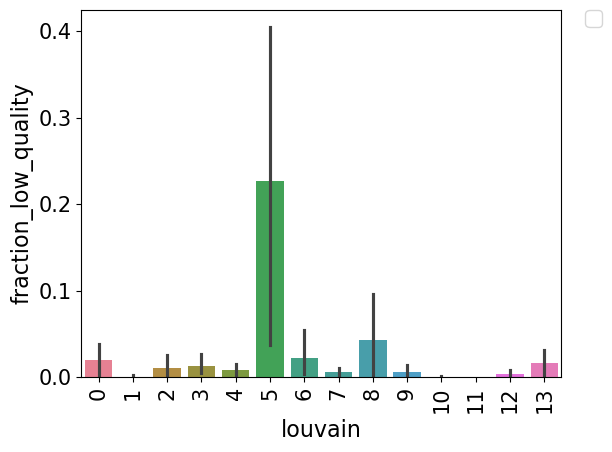

In [38]:
# plot fraction of low_quality cells for each cluster
low_quality_df = adata.obs.groupby(['cell_sample_id', 'louvain'])['low_quality'].mean().reset_index(name='fraction_low_quality')

sns.barplot(data=low_quality_df, x='louvain', y='fraction_low_quality', hue='louvain', dodge=False);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

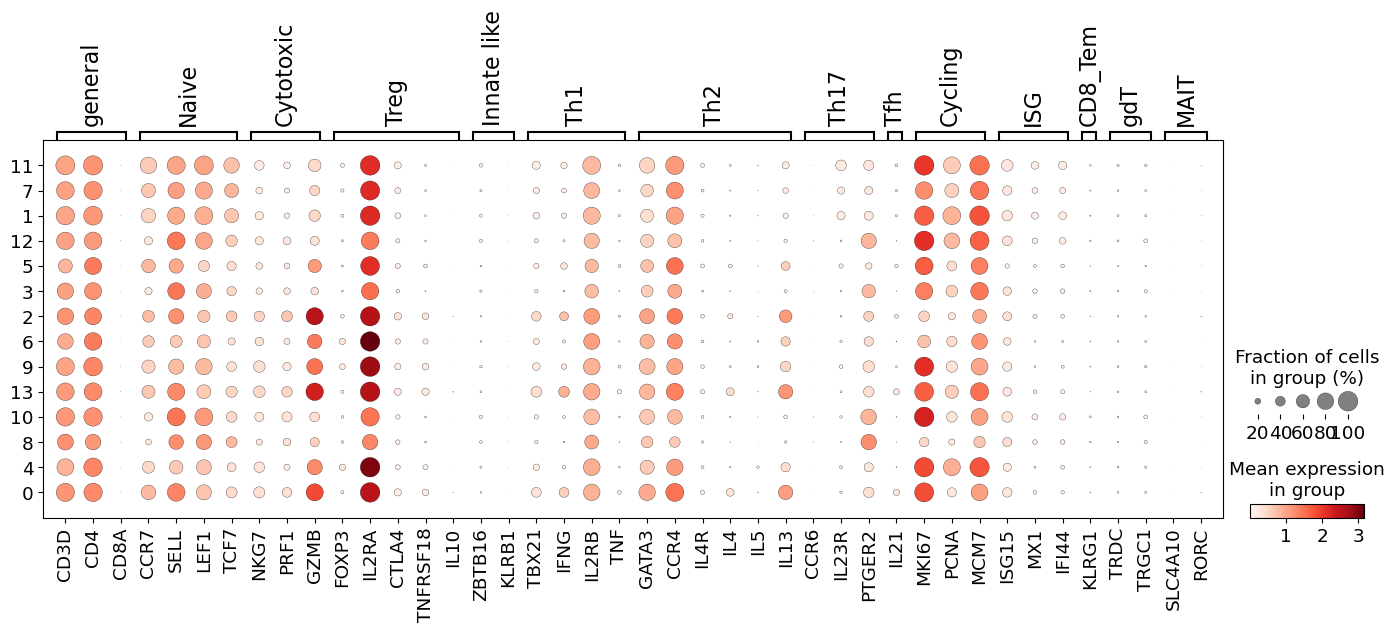

In [39]:
group_by = 'culture_condition'
markers_dict = qc_plots.load_Tcell_markers(adata)
order_samples = adata.obs.sort_values([group_by])['louvain'].astype(str).unique()
adata.obs['louvain'] = adata.obs['louvain'].cat.reorder_categories(order_samples)
sc.pl.dotplot(adata, markers_dict, groupby='louvain')


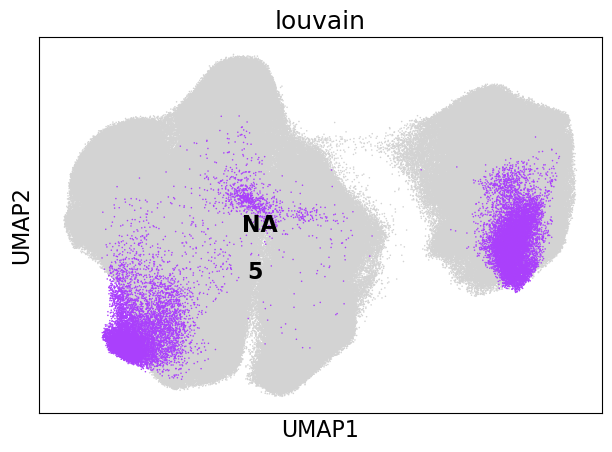

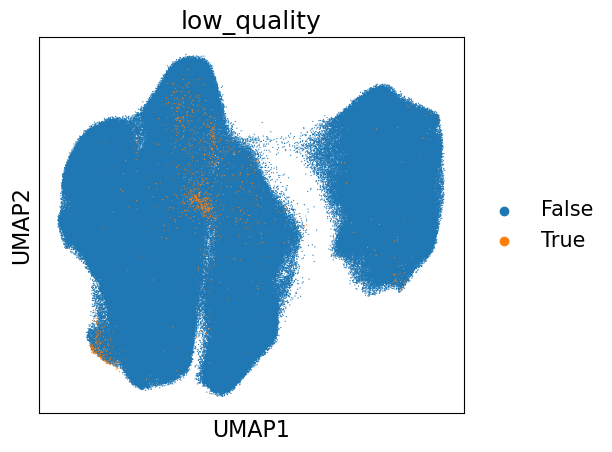

In [41]:
low_quality_clusters = ['5']
sc.pl.umap(adata, color='louvain', legend_loc='on data', size=5, groups=low_quality_clusters)
sc.pl.umap(adata, color=['low_quality'], wspace=0.4, size=3, groups=[True])

In [42]:
adata_postqc = adata[~adata.obs['louvain'].isin(low_quality_clusters)].copy()

In [43]:
adata_postqc.write_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC.h5ad')

## Knock-down efficiency

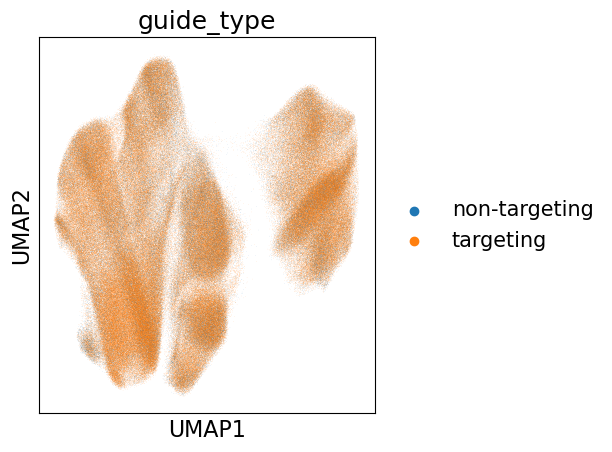

In [44]:
sc.pl.umap(adata, color='guide_type')

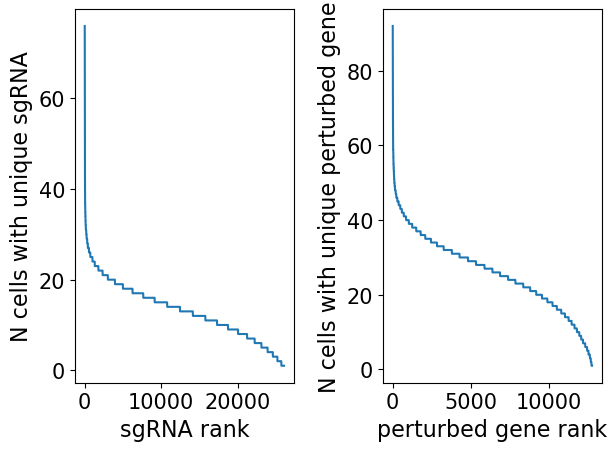

In [45]:
guide_cell_counts = adata.obs['guide_id'].value_counts()
guide_cell_counts.index = guide_cell_counts.index.astype(str)
plt.subplot(1,2,1);
plt.plot(guide_cell_counts[1:].values);
plt.xlabel('sgRNA rank');
plt.ylabel('N cells with unique sgRNA');


gene_cell_counts = adata.obs['perturbed_gene_name'].value_counts()
gene_cell_counts.index = gene_cell_counts.index.astype(str)

plt.subplot(1,2,2);
plt.plot(gene_cell_counts[1:].values);
plt.xlabel('perturbed gene rank');
plt.ylabel('N cells with unique perturbed gene');

In [46]:
perturbed_gene_expr_df = qc_plots.calculate_perturbed_gene_expression(adata)
kd_results_c = qc_plots.test_knockdown_simple(perturbed_gene_expr_df)

In [47]:
kd_results_c.to_csv(f'{datadir}/knockdown_efficacy_simple.csv')

In [48]:
kd_results_c['signif_knockdown'].shape[0]

12766

In [49]:
kd_results_c['signif_knockdown'].value_counts()

signif_knockdown
True     8664
False    4102
Name: count, dtype: int64

In [ ]:
# # Plot cumulative distributions
# plt.plot(np.sort(perturbed_gene_expr_df['perturbed_gene_expr']),
#          np.linspace(0, 1, len(perturbed_gene_expr_df['perturbed_gene_expr'])), label='Targeting')
# plt.plot(np.sort(perturbed_gene_expr_df['perturbed_gene_mean_ntc']),
#          np.linspace(0, 1, len(perturbed_gene_expr_df['perturbed_gene_mean_ntc'])), label='NTC mean')
# plt.xlabel('Expression of perturbed gene');
# plt.ylabel('Cumulative fraction');
# plt.legend()

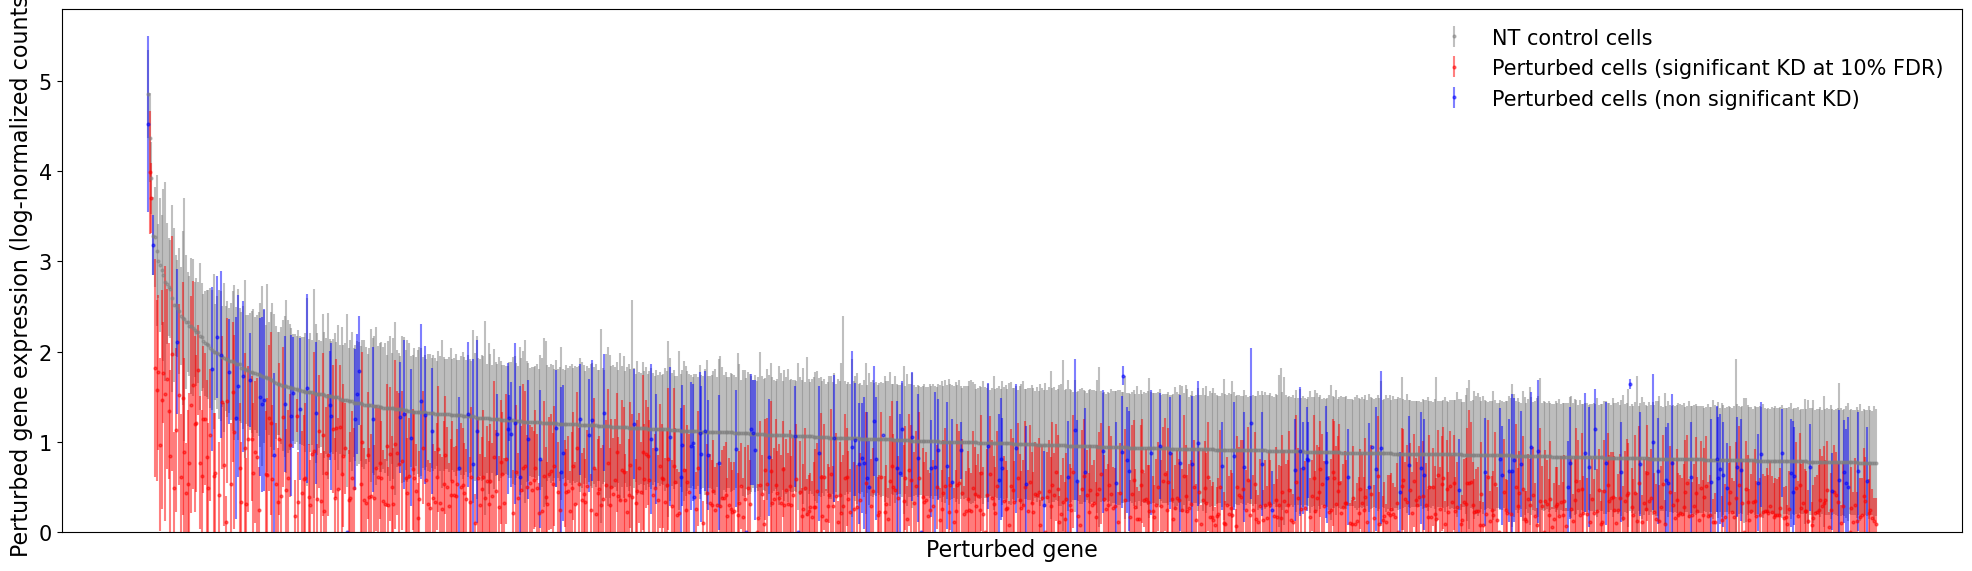

In [100]:
mean_perturbed_gene_expr_df = kd_results_c
order_genes = mean_perturbed_gene_expr_df.sort_values('perturbed_gene_mean_ntc', ascending=False).perturbed_gene.astype(str).values
mean_perturbed_gene_expr_df['perturbed_gene'] = pd.Categorical(mean_perturbed_gene_expr_df['perturbed_gene'], categories=order_genes, ordered=True)

pl_df = mean_perturbed_gene_expr_df[mean_perturbed_gene_expr_df['perturbed_gene'].isin(order_genes[0:1000])].sort_values('perturbed_gene')
plt.figure(figsize=(20,6))
# Plot mean NTC expression with error bars
plt.errorbar(pl_df['perturbed_gene'],
             pl_df['perturbed_gene_mean_ntc'], 
             yerr=pl_df['perturbed_gene_std_ntc'],
             fmt='o',
             color='grey',
             markersize=2,
             alpha=0.5,
             label='NT control cells')

# Add stripplot of perturbed expression
plt.errorbar(pl_df[pl_df.signif_knockdown]['perturbed_gene'],
           pl_df[pl_df.signif_knockdown]['perturbed_gene_expr'],
           yerr=pl_df[pl_df.signif_knockdown]['perturbed_gene_expr_std'],
           fmt='o',
           markersize=2,
           color='red',
           alpha=0.5,
           label='Perturbed cells (significant KD at 10% FDR)')
plt.errorbar(pl_df[~pl_df.signif_knockdown]['perturbed_gene'],
           pl_df[~pl_df.signif_knockdown]['perturbed_gene_expr'],
           yerr=pl_df[~pl_df.signif_knockdown]['perturbed_gene_expr_std'],
           fmt='o',
           markersize=2,
           color='blue',
           alpha=0.5,
           label='Perturbed cells (non significant KD)')

plt.xticks([])
plt.ylim(0)
plt.xlabel('Perturbed gene')
plt.ylabel('Perturbed gene expression (log-normalized counts)')
plt.legend(frameon=False);
plt.tight_layout()

Text(0, 0.5, 'Perturbed gene expression (log-normalized counts)')

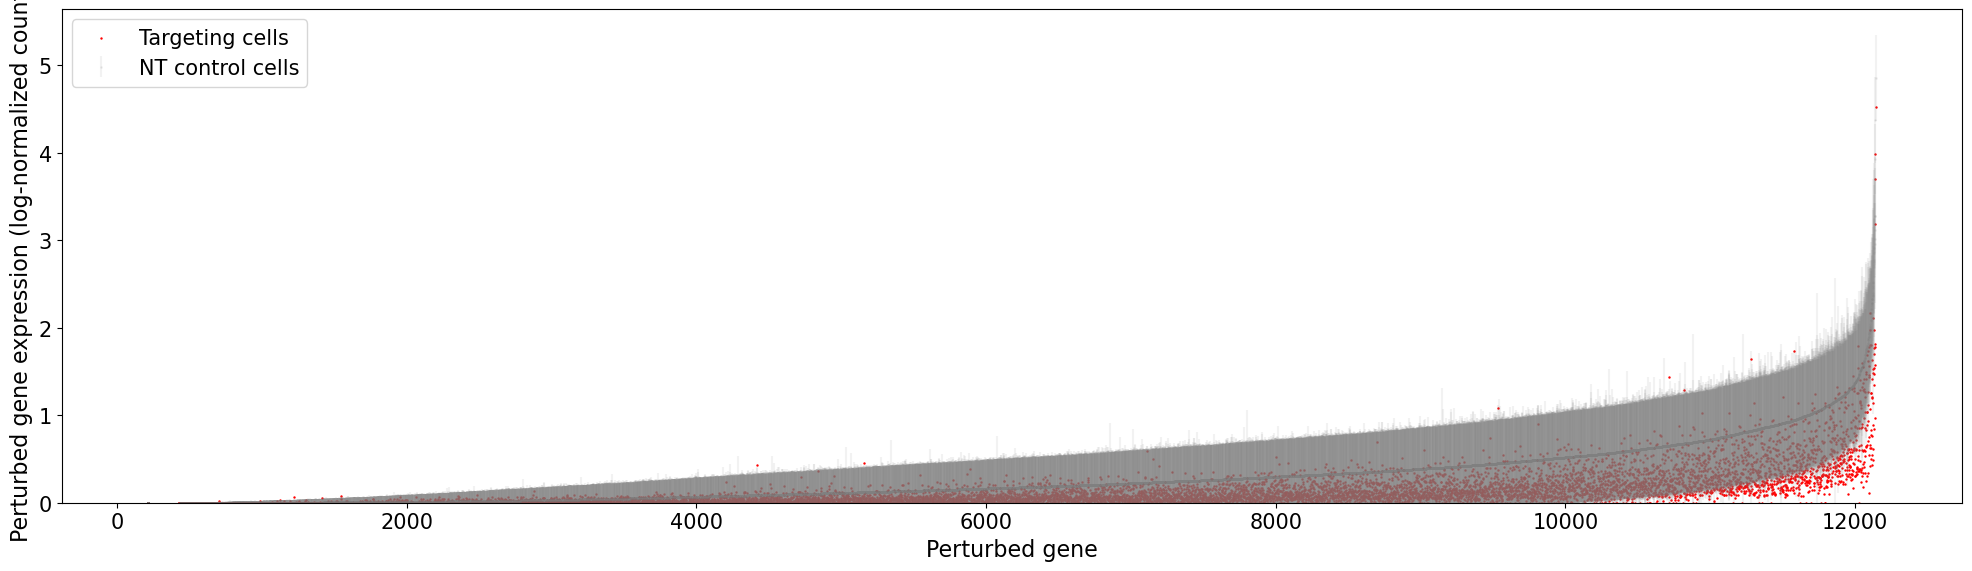

In [101]:
plt.figure(figsize=(20,6))
mean_perturbed_gene_expr_df['rank'] = mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'].rank()
# # Plot mean NTC expression with error bars
plt.errorbar(mean_perturbed_gene_expr_df['rank'],
             mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'], 
             yerr=mean_perturbed_gene_expr_df['perturbed_gene_std_ntc'],
             fmt='o',
             color='grey',
             markersize=1, 
             alpha=0.1,
             label='NT control cells')
# # Add stripplot of perturbed expression
# plt.errorbar(mean_perturbed_gene_expr_df['rank'],
#            mean_perturbed_gene_expr_df['perturbed_gene_expr'],
#            yerr=mean_perturbed_gene_expr_df['perturbed_gene_expr_std'],
#            fmt='o',
#              markersize=1, 
#              alpha=0.1,
#            color='red',
#            label='Perturbed cells (significant KD at 10% FDR)')
# # plt.errorbar(mean_perturbed_gene_expr_df[~mean_perturbed_gene_expr_df.signif_knockdown]['rank'],
# #            mean_perturbed_gene_expr_df[~mean_perturbed_gene_expr_df.signif_knockdown]['perturbed_gene_expr'],
# #            yerr=mean_perturbed_gene_expr_df[~mean_perturbed_gene_expr_df.signif_knockdown]['perturbed_gene_expr_std'],
# #            fmt='o',
# #             markersize=1, 
# #              alpha=0.1,
# #            color='blue',
# #            label='Perturbed cells (non significant KD)')

# sns.scatterplot(y=mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'], x=mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'].rank(), s=1, color='grey', label='NTC cells', linewidth=0);
sns.scatterplot(y=mean_perturbed_gene_expr_df['perturbed_gene_expr'], x=mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'].rank(), s=3, label='Targeting cells', color='red', linewidth=0);
plt.ylim(0)
plt.xlabel('Perturbed gene')
plt.ylabel('Perturbed gene expression (log-normalized counts)')


In [50]:
all_conditions = adata.obs['culture_condition'].unique()
all_conditions_tests = {}
for c in all_conditions:
    print(c)
    ad_c = adata[adata.obs['culture_condition'] == c].copy()
    perturbed_gene_expr_df = qc_plots.calculate_perturbed_gene_expression(ad_c)
    kd_results_c = qc_plots.test_knockdown_simple(perturbed_gene_expr_df)
    kd_results_c['culture_condition'] = c
    all_conditions_tests[c] = kd_results_c

Day7
Rest
Restim6hr
Restim24hr


In [51]:
for k in all_conditions_tests.keys():
    print(all_conditions_tests[k].signif_knockdown.value_counts())

signif_knockdown
True     7209
False    5417
Name: count, dtype: int64
signif_knockdown
True     7461
False    5013
Name: count, dtype: int64
signif_knockdown
True     7350
False    5121
Name: count, dtype: int64
signif_knockdown
True     7400
False    4940
Name: count, dtype: int64


## Head to head comparison with 1x loading

In [104]:
datadir

'/mnt/oak/users/emma/data/GWT/PilotD2Redo_Lane2/'

In [128]:
kd_results_c_3x = pd.read_csv(f'{datadir}/knockdown_efficacy_simple.csv', index_col=0)
kd_results_c_3x['loading'] = '3x'
kd_results_c_1x = pd.read_csv(f'/mnt/oak/users/emma/data/GWT/PilotD2Redo/knockdown_efficacy_simple.csv', index_col=0)
kd_results_c_1x['loading'] = '1x'

In [129]:
kd_results_c_3x

perturbed_gene  perturbed_gene_expr  perturbed_gene_mean_ntc  \
0                AKAP2                  NaN                      NaN   
1      ENSG00000000003             0.000000                 0.000042   
2      ENSG00000000419             0.340331                 0.981742   
3      ENSG00000000457             0.046577                 0.141797   
4      ENSG00000000460             0.038074                 0.397745   
...                ...                  ...                      ...   
12759             OCLM                  NaN                      NaN   
12760            SEPT6                  NaN                      NaN   
12761           SGK494                  NaN                      NaN   
12762          SMIM11B                  NaN                      NaN   
12763          U2AF1L5                  NaN                      NaN   

       perturbed_gene_std_ntc  n_ntc_cells  perturbed_gene_expr_std  \
0                         NaN      13731.0                      NaN   
1                    0.004964      13731.0                 0.000000   
2                    0.618526      13731.0                 0.448305   
3                    0.317077      13731.0                 0.199807   
4                    0.488343      13731.0                 0.120312   
...                       ...          ...                      ...   
12759                     NaN      13731.0                      NaN   
12760                     NaN      13731.0                      NaN   
12761                     NaN      13731.0                      NaN   
12762                     NaN      13731.0                      NaN   
12763                     NaN      13731.0                      NaN   

       n_perturbed_cells  t_statistic       p_value   adj_p_value  \
0                      0          NaN           NaN           NaN   
1                     35    -1.000036  3.173105e-01  3.658073e-01   
2                     35    -8.443951  6.794186e-10  2.042276e-09   
3                     31    -2.645867  1.278997e-02  1.894499e-02   
4                     21   -13.530102  7.612655e-12  2.574421e-11   
...                  ...          ...           ...           ...   
12759                  0          NaN           NaN           NaN   
12760                  0          NaN           NaN           NaN   
12761                  0          NaN           NaN           NaN   
12762                  0          NaN           NaN           NaN   
12763                  0          NaN           NaN           NaN   

       signif_knockdown loading  
0                 False      3x  
1                 False      3x  
2                  True      3x  
3                  True      3x  
4                  True      3x  
...                 ...     ...  
12759             False      3x  
12760             False      3x  
12761             False      3x  
12762             False      3x  
12763             False      3x  

[12764 rows x 12 columns]

Text(0, 0.5, '3x loading (mean NTC expression)')

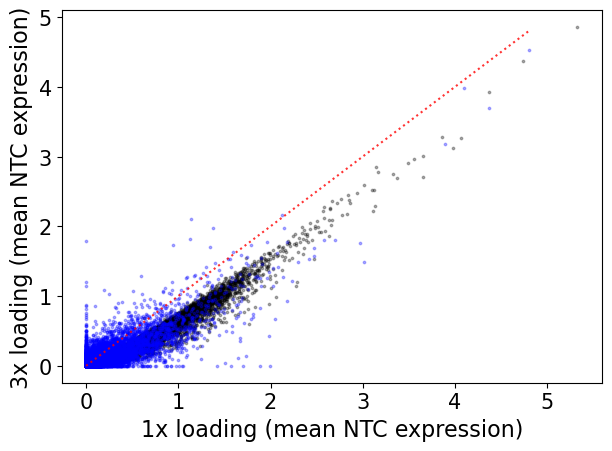

In [130]:
pl_df = pd.concat([kd_results_c_3x[['perturbed_gene', 'perturbed_gene_mean_ntc', 'loading']], kd_results_c_1x[['perturbed_gene', 'perturbed_gene_mean_ntc', 'loading']]])
pl_df = pl_df.pivot(index='perturbed_gene', columns='loading', values='perturbed_gene_mean_ntc')
plt.scatter(pl_df['1x'], pl_df['3x'], s=3, alpha=0.3, color='black')

pl_df = pd.concat([kd_results_c_3x[['perturbed_gene', 'perturbed_gene_expr', 'loading']], kd_results_c_1x[['perturbed_gene', 'perturbed_gene_expr', 'loading']]])
pl_df = pl_df.pivot(index='perturbed_gene', columns='loading', values='perturbed_gene_expr')
plt.scatter(pl_df['1x'], pl_df['3x'], s=3, alpha=0.3, color='blue')

plt.plot([pl_df.min().min(), pl_df.max().max()], [pl_df.min().min(), pl_df.max().max()], 'r:', alpha=0.8)
plt.xlabel('1x loading (mean NTC expression)')
plt.ylabel('3x loading (mean NTC expression)')


In [140]:
pl_df

loading                1x            3x
perturbed_gene                         
AKAP2                 NaN           NaN
ENSG00000000003  0.209185  3.658073e-01
ENSG00000000419  0.004830  2.042276e-09
ENSG00000000457  0.056687  1.894499e-02
ENSG00000000460  0.010909  2.574421e-11
...                   ...           ...
OCLM                  NaN           NaN
SEPT6                 NaN           NaN
SGK494                NaN           NaN
SMIM11B               NaN           NaN
U2AF1L5               NaN           NaN

[12775 rows x 2 columns]

In [142]:
pl_df = pd.concat([kd_results_c_3x[['perturbed_gene', 'adj_p_value', 'loading']], kd_results_c_1x[['perturbed_gene', 'adj_p_value', 'loading']]])
pl_df = pl_df.pivot(index='perturbed_gene', columns='loading', values='adj_p_value')
((pl_df['3x'] < 0.1) & (pl_df['1x'] >= 0.1)).sum

1344

Text(0, 0.5, '3x loading (mean NTC expression)')

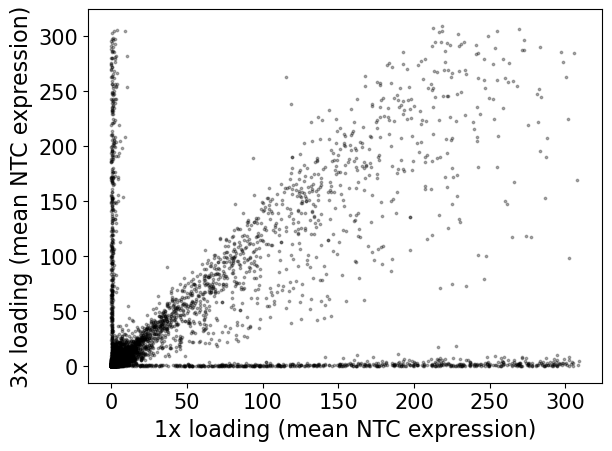

In [134]:
pl_df = pd.concat([kd_results_c_3x[['perturbed_gene', 'adj_p_value', 'loading']], kd_results_c_1x[['perturbed_gene', 'adj_p_value', 'loading']]])
pl_df = pl_df.pivot(index='perturbed_gene', columns='loading', values='adj_p_value')
plt.scatter(-np.log10(pl_df['1x']), -np.log10(pl_df['3x']), s=3, alpha=0.3, color='black')
# plt.scatter(pl_df['1x'], pl_df['3x'], s=3, alpha=0.3, color='black')

plt.xlabel('1x loading (mean NTC expression)')
plt.ylabel('3x loading (mean NTC expression)')